# One Class Classification for Doges
<br>
<img src="https://blogtienso.vn/wp-content/uploads/2020/10/BIA-DOG.png" alt="Car" title="Car" />


## Preparing Train, Test, and Validation Data

The training data is comprised of ONLY positive images (the ones with doge). The validation and test data contain both positive and negative images.

In [ ]:
# import libraries
from IPython.display import Image, display
import numpy as np
import os
from os.path import join
from PIL import ImageFile, Image
import pandas as pd
from matplotlib import cm
import seaborn as sns
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.mixture import GaussianMixture
from sklearn.isotonic import IsotonicRegression
import re

ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.style.use('fivethirtyeight')
%matplotlib inline

In [ ]:
image_size = 224
resnet_model = ResNet50(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False, pooling='avg')

94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# import doge images
train_img_dir = "/content/drive/MyDrive/doge/positive"
all_train_img_paths = [join(train_img_dir,filename) for filename in os.listdir(train_img_dir)]
all_train_img_paths = all_train_img_paths[:3000]

# split doge data into train, test, and val
train_img_paths, test_img_paths_pos = train_test_split(all_train_img_paths, test_size=0.25, random_state=42)
train_img_paths, val_img_paths_pos = train_test_split(train_img_paths, test_size=0.25, random_state=42)

In [ ]:
#  import negative images
negative_images_path = "/content/drive/MyDrive/doge/negative"
    
test_img_paths_neg = [join(negative_images_path, filename) for filename in os.listdir(negative_images_path)]
test_img_paths_neg = test_img_paths_neg[:4000]
test_img_paths_neg, val_img_paths_neg = train_test_split(test_img_paths_neg, test_size = 0.25, random_state = 42)

In [ ]:
def natural_img_dir(image_path):
    path_regex = r"natural_images\/(\w*)"
    if 'negative' in image_path:
        return "negative"
    else:
        return 'positive'

In [ ]:
# create test dataframe
all_test_paths = test_img_paths_pos + test_img_paths_neg
test_path_df = pd.DataFrame({
    'path': all_test_paths,
    'is_doge': [1 if path in test_img_paths_pos else 0 for path in all_test_paths]
})
test_path_df = shuffle(test_path_df,random_state = 0).reset_index(drop = True)
test_path_df['image_type'] = test_path_df['path'].apply(lambda x: natural_img_dir(x))
all_test_paths = test_path_df['path'].tolist()

In [ ]:
print('Distribution of Image Types in Test Set')
print(test_path_df['image_type'].value_counts())

Distribution of Image Types in Test Set
negative    3000
positive     750
Name: image_type, dtype: int64


In [ ]:
# create val dataframe
all_val_paths = val_img_paths_pos + val_img_paths_neg
val_path_df = pd.DataFrame({
    'path': all_val_paths,
    'is_doge': [1 if path in val_img_paths_pos else 0 for path in all_val_paths]
})
val_path_df = shuffle(val_path_df,random_state = 0).reset_index(drop = True)
val_path_df['image_type'] = val_path_df['path'].apply(lambda x: natural_img_dir(x))
all_val_paths = val_path_df['path'].tolist()

In [ ]:
print('Distribution of Image Types in Validation Set')
print(val_path_df['image_type'].value_counts())

Distribution of Image Types in Validation Set
negative    1000
positive     563
Name: image_type, dtype: int64


## Feature Extraction With ResNet50
Removing the prediction layer of the pretrained Resnet50 model allows features to quickly be extracted from selected images.

In [ ]:
# prepare images for resnet50
image_size = 224

def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    #output = img_array
    output = preprocess_input(img_array)
    return(output)

X_train = read_and_prep_images(train_img_paths)
X_test = read_and_prep_images(all_test_paths)
X_val = read_and_prep_images(all_val_paths)

In [ ]:
# get features from resnet50 

X_train = resnet_model.predict(X_train)
X_test = resnet_model.predict(X_test)
X_val = resnet_model.predict(X_val)

## Scaling and PCA
Reducing the dimensionality of extracted features allow for quicker training times.

In [ ]:
# Apply standard scaler to output from resnet50
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)
X_val = ss.transform(X_val)

# Take PCA to reduce feature space dimensionality
pca = PCA(n_components=230, whiten=True)
pca = pca.fit(X_train)
print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

Explained variance percentage = 0.94


## One Class SVM vs Isolation Forest

These two models can be trained on solely positive class (doges for this project) without the need for a validation set.

In [ ]:
# Train classifier and obtain predictions for OC-SVM
oc_svm_clf = svm.OneClassSVM(gamma=0.001, kernel='rbf', nu=0.08)  # Obtained using grid search
if_clf = IsolationForest(contamination=0.08, max_features=1.0, max_samples=1.0, n_estimators=40)  # Obtained using grid search

oc_svm_clf.fit(X_train)
if_clf.fit(X_train)

oc_svm_preds = oc_svm_clf.predict(X_test)
if_preds = if_clf.predict(X_test)

# Further compute accuracy, precision and recall for the two predictions sets obtained

In [ ]:
svm_if_results=pd.DataFrame({
  'path': all_test_paths,
  'oc_svm_preds': [0 if x == -1 else 1 for x in oc_svm_preds],
  'if_preds': [0 if x == -1 else 1 for x in if_preds]
})


svm_if_results=svm_if_results.merge(test_path_df)
svm_if_results.head()

,path,oc_svm_preds,if_preds,is_doge,image_type
0,/content/drive/MyDrive/doge/negative/272_crop_...,1,1,0,negative
1,/content/drive/MyDrive/doge/negative/306_crop_...,0,0,0,negative
2,/content/drive/MyDrive/doge/negative/417_crop_...,0,0,0,negative
3,/content/drive/MyDrive/doge/negative/300_crop_...,0,0,0,negative
4,/content/drive/MyDrive/doge/negative/334_crop_...,1,1,0,negative


roc auc score: if_preds
0.8460000000000001
              precision    recall  f1-score   support

           0       0.98      0.74      0.85      3000
           1       0.48      0.95      0.64       750

    accuracy                           0.78      3750
   macro avg       0.73      0.85      0.74      3750
weighted avg       0.88      0.78      0.80      3750



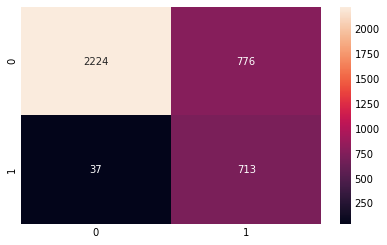

In [ ]:
print('roc auc score: if_preds')
if_preds=svm_if_results['if_preds']
actual=svm_if_results['is_doge']
print(roc_auc_score(actual, if_preds))
print(classification_report(actual, if_preds))
sns.heatmap(confusion_matrix(actual, if_preds),annot=True,fmt='2.0f')
plt.show()

roc auc score: oc_svm_preds
0.8833333333333335
              precision    recall  f1-score   support

           0       0.99      0.82      0.89      3000
           1       0.56      0.95      0.71       750

    accuracy                           0.84      3750
   macro avg       0.77      0.88      0.80      3750
weighted avg       0.90      0.84      0.86      3750



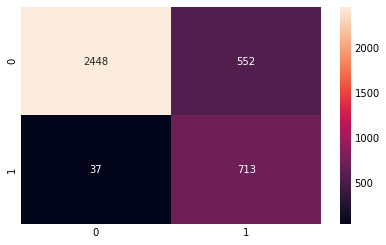

In [ ]:
print('roc auc score: oc_svm_preds')
oc_svm_preds=svm_if_results['oc_svm_preds']
actual=svm_if_results['is_doge']
print(roc_auc_score(actual, oc_svm_preds))
print(classification_report(actual, oc_svm_preds))
sns.heatmap(confusion_matrix(actual, oc_svm_preds),annot=True,fmt='2.0f')
plt.show()

## Gaussian Mixture and Isotonic Regression
These models leverage validation data to additionally learn distinctions between positive and not positive class images. With real world problems, the data scientist might have a hunch on what "not positive images" might appear alongside its positive counterparts; these selections would be appropriate to include in the validation data. For example, a marine biologist may ask a data scientist to perform One Class Clasification to return only images with a shark in the photo. To leverage the GMM model below, the data scientist might choose to also include non-shark fishes, whales, and open ocean images in the validation data alongside some shark images.

In [ ]:
y_val = val_path_df['is_doge'].tolist()

gmm_clf = GaussianMixture(covariance_type='spherical', n_components=18, max_iter=int(1e7))  # From Article (These params should be optimized for this problem)
gmm_clf.fit(X_train)
log_probs_val = gmm_clf.score_samples(X_val)
isotonic_regressor = IsotonicRegression(out_of_bounds='clip')
isotonic_regressor.fit(log_probs_val, y_val)  # y_val is for labels 0 - not car 1 - car (validation set)

# Obtaining results on the test set
log_probs_test = gmm_clf.score_samples(X_test)
test_probabilities = isotonic_regressor.predict(log_probs_test)
test_predictions = [1 if prob >= 0.5 else 0 for prob in test_probabilities]


,path,gmm_preds,is_doge,image_type
0,/content/drive/MyDrive/doge/negative/272_crop_...,1,0,negative
1,/content/drive/MyDrive/doge/negative/306_crop_...,0,0,negative
2,/content/drive/MyDrive/doge/negative/417_crop_...,0,0,negative
3,/content/drive/MyDrive/doge/negative/300_crop_...,0,0,negative
4,/content/drive/MyDrive/doge/negative/334_crop_...,0,0,negative


roc auc score: gmm_preds
0.8726666666666667
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      3000
           1       0.58      0.91      0.71       750

    accuracy                           0.85      3750
   macro avg       0.78      0.87      0.81      3750
weighted avg       0.90      0.85      0.86      3750



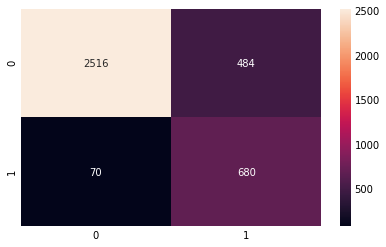

In [ ]:
print('roc auc score: gmm_preds')
gmm_preds = gmm_results['gmm_preds']
actual = gmm_results['is_doge']
print(roc_auc_score(actual, gmm_preds))
print(classification_report(actual, gmm_preds))
sns.heatmap(confusion_matrix(actual, gmm_preds),annot = True,fmt = '2.0f')
plt.show()

## Error Analysis

The OC SVM and IF models had fewer False Positives but more False Negatives compared to the GMM model, with the OC SVM model outperforming the IF one. Depending on the use case of a project, it might be wiser to choose the OC SVM over the GMM or vice versa. A fulfillment center might opt to use the OC SVM model as it has fewer False Positives, meaning when it chooses to pack an object, such as a toy car, it is more likely to pack the right object than the GMM model. However, a healthcare imaging device may be favor the GMM more, as making a False Negative is much more costly to the patient than a False Positive.

Looking at the types of images of the False Positives, it isn't surprising to see that motorbikes were the most commonly mispredicted as a car as the presence of wheels and metal chassis share similarities.

A naive look at the cars in the False Negative class show that images of exotic cars and cars shot at atypical angles or with other objects in the view were among the cars mispredicted as non-cars.

In [ ]:
print('False Positive Actual Image Types for OC SVM: ')
print(svm_if_results[svm_if_results['oc_svm_preds']>svm_if_results['is_doge']]['image_type'].value_counts())

False Positive Actual Image Types for OC SVM: 
negative    552
Name: image_type, dtype: int64


In [ ]:
import pickle as pk

In [ ]:
!ls

drive  sample_data


In [ ]:
pk.dump(pca, open("./drive/MyDrive/1-clf_models/pca.pkl","wb"))
pk.dump(ss, open("./drive/MyDrive/1-clf_models/ss.pkl","wb"))
pk.dump(oc_svm_clf, open("./drive/MyDrive/1-clf_models/oc_svm_clf.pkl","wb"))

In [ ]:
svm_reload = pk.load(open("./drive/MyDrive/1-clf_models/oc_svm_clf.pkl",'rb'))

In [ ]:
svm_reload.predict(X_test))

3750

In [ ]:
# import positive tweets
pos_tweet_dir = "/content/drive/MyDrive/tweets/pos_tweet/"
all_pos_tweet_path = [join(pos_tweet_dir,filename) for filename in os.listdir(pos_tweet_dir)]

In [ ]:
#  import negative images
neg_tweet_dir = "/content/drive/MyDrive/tweets/neg_tweet/"
all_neg_tweet_path = [join(neg_tweet_dir, filename) for filename in os.listdir(neg_tweet_dir)]

In [ ]:
# create test dataframe
all_tweet_paths = all_pos_tweet_path + all_neg_tweet_path
tweet_df = pd.DataFrame({
    'path': all_tweet_paths,
    'is_doge': [1 if path in all_pos_tweet_path else 0 for path in all_tweet_paths]
})
tweet_df = shuffle(tweet_df,random_state = 0).reset_index(drop = True)
all_tweet_paths = tweet_df['path'].tolist()

In [ ]:
def read_and_prep_images_padding(img_paths, img_height=image_size, img_width=image_size):
    imgs = []
    for img_path in img_paths:
      img = Image.open(img_path)
      old_size = img.size
      ratio = float(img_height)/max(old_size)
      new_size = tuple([int(x*ratio) for x in old_size])
      img = img.resize(new_size, Image.ANTIALIAS)
      transformed_img = Image.new("RGB", (img_height, img_height))
      transformed_img.paste(img, ((img_height-new_size[0])//2,
                          (img_height-new_size[1])//2))
      imgs.append(transformed_img)

    img_array = np.array([img_to_array(img) for img in imgs])

    #output = img_array
    output = preprocess_input(img_array)
    return(output)

In [ ]:
# Prepare image to feed into resnet50
X_test_tweet = read_and_prep_images_padding(all_tweet_paths)

In [ ]:
# get features from resnet50 
X_test_tweet = resnet_model.predict(X_test_tweet)

In [ ]:
# Apply standard scaler to output from resnet50
X_test_tweet = ss.transform(X_test_tweet)

# Take PCA to reduce feature space dimensionality
X_test_tweet = pca.transform(X_test_tweet)

In [ ]:
tweet_preds = oc_svm_clf.predict(X_test_tweet)
tweet_preds = np.where(tweet_preds==-1, 0, tweet_preds)

actual = tweet_df['is_doge']

In [ ]:
log_probs_test = gmm_clf.score_samples(X_test_tweet)
test_probabilities = isotonic_regressor.predict(log_probs_test)
test_predictions = [1 if prob >= 0.5 else 0 for prob in test_probabilities]

In [ ]:
max(test_predictions)

1

ROC-AUC score: One-class SVM
0.5649678604224059
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       726
           1       0.03      0.22      0.05         9

    accuracy                           0.90       735
   macro avg       0.51      0.56      0.50       735
weighted avg       0.98      0.90      0.94       735



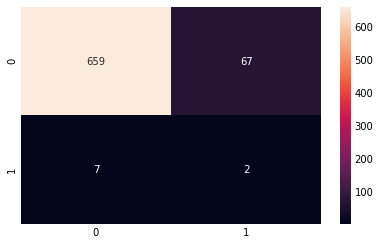

In [ ]:
print('ROC-AUC score: One-class SVM')
print(roc_auc_score(actual, test_predictions))
print(classification_report(actual, test_predictions))
sns.heatmap(confusion_matrix(actual, test_predictions),annot = True,fmt = '2.0f')
plt.show()

In [ ]:
for index, row in svm_if_results[svm_if_results['oc_svm_preds']!=svm_if_results['is_doge']].head(25).iterrows():
    if row['oc_svm_preds']==1:
        print('FALSE POSITIVE')
        print('oc_svm_preds: ' + str(row['oc_svm_preds']) + ' | actual: '+ str(row['is_doge']))
        display(Image(row['path']))
    else:
        print('FALSE NEGATIVE')
        print('oc_svm_preds: ' + str(row['oc_svm_preds']) + ' | actual: '+ str(row['is_doge']))
        display(Image(row['path']))

FALSE POSITIVE
oc_svm_preds: 1 | actual: 0


TypeError: ignored

In [ ]:
print('False Positive Actual Image Types for IF: ')
print(svm_if_results[svm_if_results['if_preds']>svm_if_results['is_doge']]['image_type'].value_counts())

False Positive Actual Image Types for IF: 
negative    776
Name: image_type, dtype: int64


In [ ]:
for index, row in svm_if_results[svm_if_results['if_preds']!=svm_if_results['is_doge']].head(25).iterrows():
    if row['if_preds']==1:
        print('FALSE POSITIVE')
        print('if_preds: ' + str(row['if_preds']) + ' | actual: '+ str(row['is_doge']))
        display(Image(row['path']))
    else:
        print('FALSE NEGATIVE')
        print('if_preds: ' + str(row['if_preds']) + ' | actual: '+ str(row['is_doge']))
        display(Image(row['path']))

FALSE POSITIVE
if_preds: 1 | actual: 0


TypeError: ignored

In [ ]:
print('False Positive Actual Image Types for GMM: ')
print(gmm_results[gmm_results['gmm_preds']>gmm_results['is_doge']]['image_type'].value_counts())

False Positive Actual Image Types for GMM: 
negative    74
Name: image_type, dtype: int64


FALSE POSITIVE
gmm_preds: 1 | actual: 0


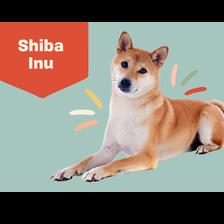

FALSE POSITIVE
gmm_preds: 1 | actual: 0


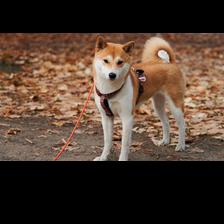

FALSE NEGATIVE
gmm_preds: 0 | actual: 1


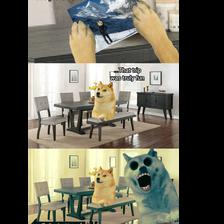

FALSE NEGATIVE
gmm_preds: 0 | actual: 1


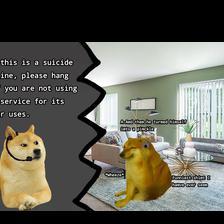

FALSE POSITIVE
gmm_preds: 1 | actual: 0


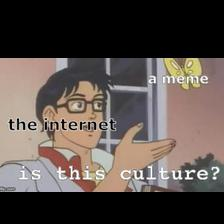

FALSE POSITIVE
gmm_preds: 1 | actual: 0


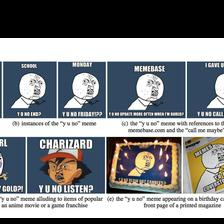

FALSE POSITIVE
gmm_preds: 1 | actual: 0


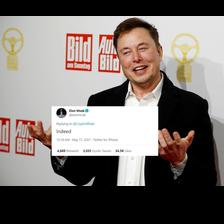

FALSE POSITIVE
gmm_preds: 1 | actual: 0


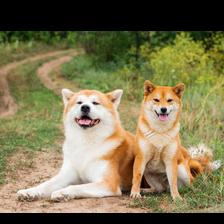

FALSE POSITIVE
gmm_preds: 1 | actual: 0


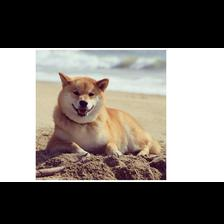

FALSE POSITIVE
gmm_preds: 1 | actual: 0


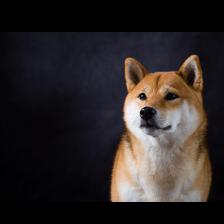

FALSE POSITIVE
gmm_preds: 1 | actual: 0


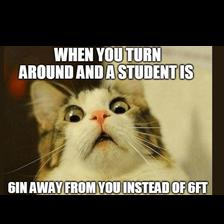

FALSE POSITIVE
gmm_preds: 1 | actual: 0


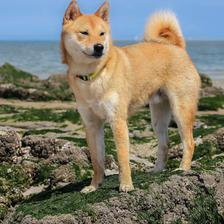

FALSE POSITIVE
gmm_preds: 1 | actual: 0


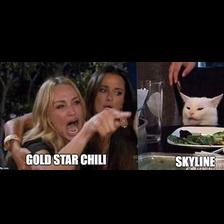

FALSE NEGATIVE
gmm_preds: 0 | actual: 1


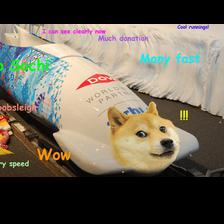

FALSE POSITIVE
gmm_preds: 1 | actual: 0


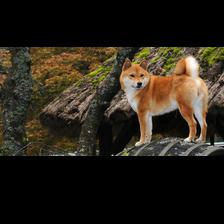

FALSE POSITIVE
gmm_preds: 1 | actual: 0


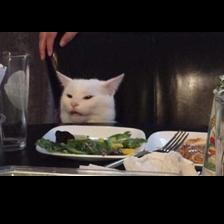

FALSE POSITIVE
gmm_preds: 1 | actual: 0


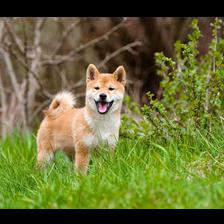

FALSE POSITIVE
gmm_preds: 1 | actual: 0


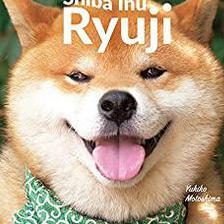

FALSE POSITIVE
gmm_preds: 1 | actual: 0


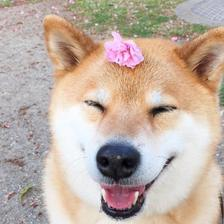

FALSE POSITIVE
gmm_preds: 1 | actual: 0


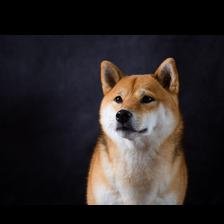

FALSE POSITIVE
gmm_preds: 1 | actual: 0


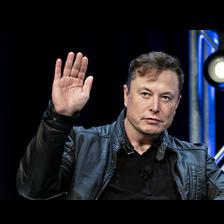

FALSE POSITIVE
gmm_preds: 1 | actual: 0


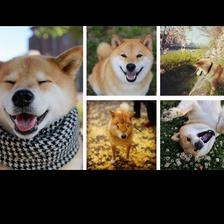

FALSE POSITIVE
gmm_preds: 1 | actual: 0


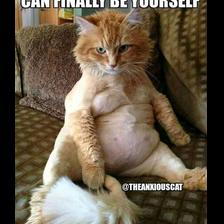

FALSE POSITIVE
gmm_preds: 1 | actual: 0


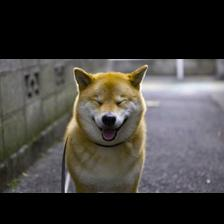

FALSE POSITIVE
gmm_preds: 1 | actual: 0


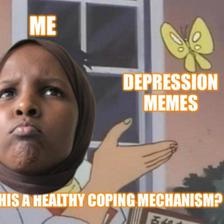

In [ ]:
for index, row in gmm_results[gmm_results['gmm_preds']!=gmm_results['is_doge']].head(25).iterrows():
    if row['gmm_preds']==1:
        print('FALSE POSITIVE')
        print('gmm_preds: ' + str(row['gmm_preds']) + ' | actual: '+ str(row['is_doge']))
        display(Image(row['path']))
    else:
        print('FALSE NEGATIVE')
        print('gmm_preds: ' + str(row['gmm_preds']) + ' | actual: '+ str(row['is_doge']))
        display(Image(row['path']))

In [ ]:
end = time.time()

In [ ]:
while True:
  pass

## Closing Remarks

I hope this notebook was helpful for those interested in learning a bit more about One Class Image Classification and its application toward solving real world problems. I definitely encourage the community to contribute toward handling this tricky problem with other methods that may promise even better results. Thanks to Aniket who wrote the original article on Hackernoon.